In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
import numpy as np

In [3]:
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 

# display plots in this notebook
%matplotlib inline

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
Z_dim = 100
h_dim = 128
batch_size = 128

In [6]:
X = tf.placeholder(tf.float32, shape=[None, X_dim], name='X')
y = tf.placeholder(tf.float32, shape=[None, y_dim], name='y')

In [7]:
with tf.variable_scope('D') as scope:
    D_W1 = tf.get_variable('W1', shape=[X_dim + y_dim, h_dim], initializer=tf.contrib.layers.xavier_initializer())
    D_b1 = tf.get_variable('b1', shape=[h_dim], initializer=tf.zeros_initializer())
    D_W2 = tf.get_variable('W2', shape=[h_dim, 1], initializer=tf.contrib.layers.xavier_initializer())
    D_b2 = tf.get_variable('b2', shape=[1], initializer=tf.zeros_initializer())

In [8]:
var_D = [D_W1, D_b1, D_W2, D_b2]

In [9]:
Z = tf.placeholder(tf.float32, shape=[None, Z_dim], name='Z')

In [10]:
with tf.variable_scope('G') as scope:
    G_W1 = tf.get_variable('W1', shape=[Z_dim + y_dim, h_dim], initializer=tf.contrib.layers.xavier_initializer())
    G_b1 = tf.get_variable('b1', shape=[h_dim], initializer=tf.zeros_initializer())
    G_W2 = tf.get_variable('W2', shape=[h_dim, X_dim], initializer=tf.contrib.layers.xavier_initializer())
    G_b2 = tf.get_variable('b2', shape=[X_dim], initializer=tf.zeros_initializer())

In [11]:
var_G = [G_W1, G_b1, G_W2, G_b2]

In [12]:
def sample_Z(m, n):
    return np.random.uniform(-1, 1, size=[m, n])

In [13]:
def generator(z, y):
    inputs = tf.concat([z, y], axis=1)
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_logit = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_logit)
    
    return G_prob

In [14]:
def discriminator(x, y):
    inputs = tf.concat([x, y], axis=1)
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)
    
    return D_prob, D_logit

In [15]:
G_sample = generator(Z, y)
D_prob_real, D_logit_real = discriminator(X, y)
D_prob_fake, D_logit_fake = discriminator(G_sample, y)

In [16]:
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))

D_loss = D_loss_real + D_loss_fake

In [17]:
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

In [18]:
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=var_D)

In [19]:
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=var_G)

In [20]:
saver = tf.train.Saver(max_to_keep=5)

samples_dict = {}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100000):
        if i % 1000 == 0:
            n_samples = 16
            y_sample = np.zeros(shape=[n_samples, y_dim])
            for k in range(n_samples):
                y_sample[k, np.random.randint(0, y_dim)] = 1
            samples = sess.run(G_sample, feed_dict={y: y_sample, Z: sample_Z(n_samples, Z_dim)})
            samples_dict[i] = samples
        
        X_mb, y_mb = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, y: y_mb, Z: sample_Z(batch_size, Z_dim)})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={y: y_mb, Z: sample_Z(batch_size, Z_dim)})
        
        if i % 1000 == 0:
            print "Iter: {}".format(i)
            print "D loss: {:.4}".format(D_loss_curr)
            print "G loss: {:.4}".format(G_loss_curr)
            
            saver.save(sess, 'save/conditional_GAN/conditional_GAN', global_step=i)

Iter: 0
D loss: 1.095
G loss: 2.727
Iter: 1000
D loss: 0.006337
G loss: 6.315
Iter: 2000
D loss: 0.02544
G loss: 5.397
Iter: 3000
D loss: 0.05623
G loss: 5.8
Iter: 4000
D loss: 0.1127
G loss: 6.403
Iter: 5000
D loss: 0.2415
G loss: 5.245
Iter: 6000
D loss: 0.4015
G loss: 4.342
Iter: 7000
D loss: 0.4276
G loss: 3.992
Iter: 8000
D loss: 0.4444
G loss: 4.362
Iter: 9000
D loss: 0.4403
G loss: 3.127
Iter: 10000
D loss: 0.7815
G loss: 2.72
Iter: 11000
D loss: 0.7691
G loss: 2.731
Iter: 12000
D loss: 0.6258
G loss: 3.285
Iter: 13000
D loss: 0.6803
G loss: 2.76
Iter: 14000
D loss: 0.8504
G loss: 2.438
Iter: 15000
D loss: 1.085
G loss: 2.111
Iter: 16000
D loss: 0.7681
G loss: 2.009
Iter: 17000
D loss: 0.9182
G loss: 1.827
Iter: 18000
D loss: 0.6815
G loss: 1.982
Iter: 19000
D loss: 0.8129
G loss: 2.507
Iter: 20000
D loss: 0.8879
G loss: 2.148
Iter: 21000
D loss: 0.8758
G loss: 1.598
Iter: 22000
D loss: 0.8852
G loss: 1.815
Iter: 23000
D loss: 0.8628
G loss: 1.933
Iter: 24000
D loss: 1.006
G los

INFO:tensorflow:Restoring parameters from save/conditional_GAN/conditional_GAN-99000
7


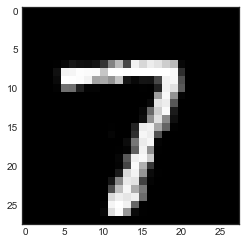

In [33]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('save/conditional_GAN'))
    
    n_samples = 1
    y_sample = np.zeros(shape=[n_samples, y_dim])
    for k in range(n_samples):
        digit = np.random.randint(0, y_dim)
        y_sample[k, digit] = 1
    samples = sess.run(G_sample, feed_dict={y: y_sample, Z: sample_Z(n_samples, Z_dim)})
    print digit
    plt.imshow(samples[0,:].reshape((28,28)), cmap='gray')